[View in Colaboratory](https://colab.research.google.com/github/sqlwu/kaggle/blob/master/Titanic_Top.ipynb)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')



/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
!pip install xlrd

# acquire data
from google.colab import files

uploads = files.upload()

train = pd.read_csv('train_Titanic.csv',dtype={"Age": np.float64})
test = pd.read_csv('test_Titanic.csv',dtype={"Age": np.float64})

PassengerId=test['PassengerId']
all_data = pd.concat([train, test], ignore_index = True)

    100% |████████████████████████████████| 112kB 2.6MB/s 


Saving test_Titanic.csv to test_Titanic.csv
Saving train_Titanic.csv to train_Titanic.csv


Percentage of females who survived:74.20
Percentage of males who survived:18.89


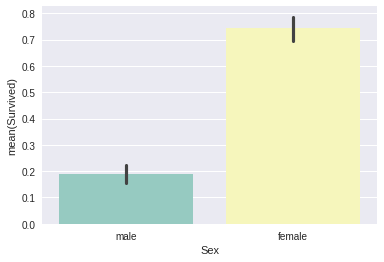

In [3]:
sns.barplot(x="Sex", y="Survived", data=train, palette='Set3')
print("Percentage of females who survived:%.2f" % (train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100))
print("Percentage of males who survived:%.2f" % (train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100))
#Sex Feature：女性幸存率远高于男性

Percentage of Pclass = 1 who survived:62.96
Percentage of Pclass = 2 who survived:47.28
Percentage of Pclass = 3 who survived:24.24


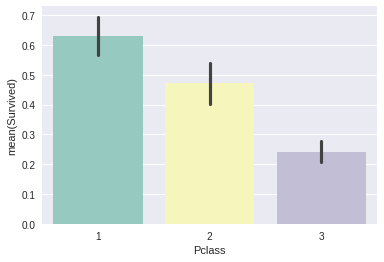

In [4]:
sns.barplot(x="Pclass", y="Survived", data=train, palette='Set3')
print("Percentage of Pclass = 1 who survived:%.2f" % (train["Survived"][train["Pclass"] == 1].value_counts(normalize = True)[1]*100))
print("Percentage of Pclass = 2 who survived:%.2f" % (train["Survived"][train["Pclass"] == 2].value_counts(normalize = True)[1]*100))
print("Percentage of Pclass = 3 who survived:%.2f" % (train["Survived"][train["Pclass"] == 3].value_counts(normalize = True)[1]*100))
#Pclass Feature：乘客社会等级越高，幸存率越高

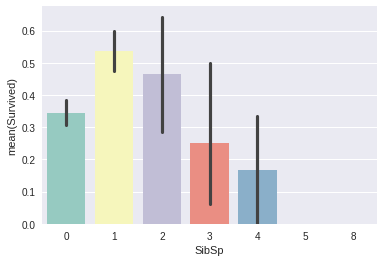

In [5]:
sns.barplot(x="SibSp", y="Survived", data=train, palette='Set3')
#SibSp Feature：配偶及兄弟姐妹数适中的乘客幸存率更高

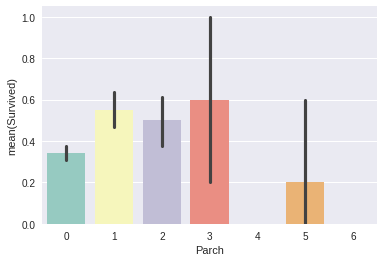

In [6]:
sns.barplot(x="Parch", y="Survived", data=train, palette='Set3')
#Parch Feature：父母与子女数适中的乘客幸存率更高

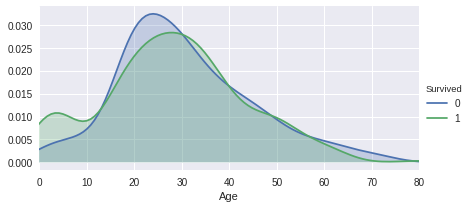

In [7]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
#Age Feature：未成年人幸存率高于成年人

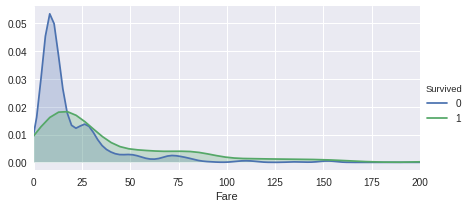

In [8]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 200))
facet.add_legend()
#Fare Feature：支出船票费越高幸存率越高

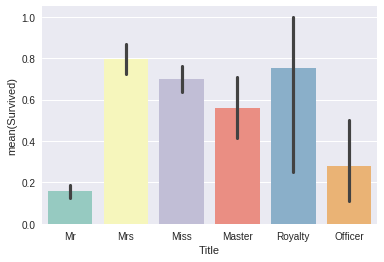

In [9]:
#新增Title特征，从姓名中提取乘客的称呼，归纳为六类。
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x="Title", y="Survived", data=all_data, palette='Set3')
#Title Feature(New)：不同称呼的乘客幸存率不同

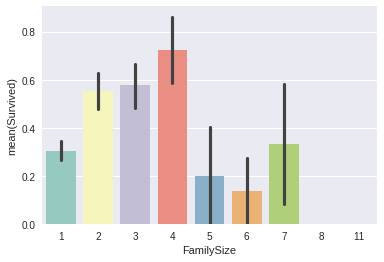

In [10]:
#新增FamilyLabel特征，先计算FamilySize=Parch+SibSp+1，然后把FamilySize分为三类。
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=all_data, palette='Set3')
#FamilyLabel Feature(New)：家庭人数为2到4的乘客幸存率较高

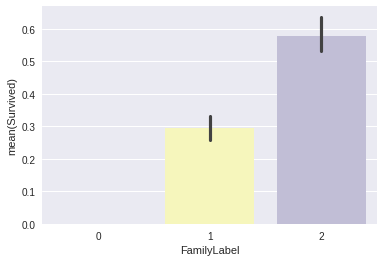

In [11]:
#按生存率把FamilySize分为三类，构成FamilyLabel特征。
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data, palette='Set3')

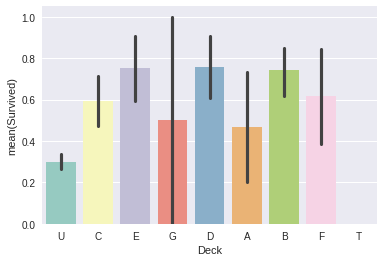

In [12]:
#新增Deck特征，先把Cabin空缺值填充为'Unknown'，再提取Cabin中的首字母构成乘客的甲板号。
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data, palette='Set3')
#Deck Feature(New)：不同甲板的乘客幸存率不同

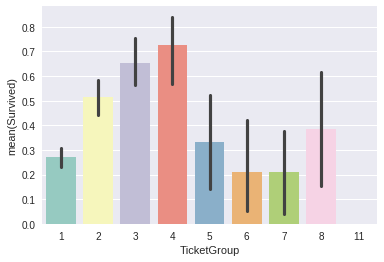

In [13]:
#新增TicketGroup特征，统计每个乘客的共票号数。
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')
#TicketGroup Feature(New)：与2至4人共票号的乘客幸存率较高

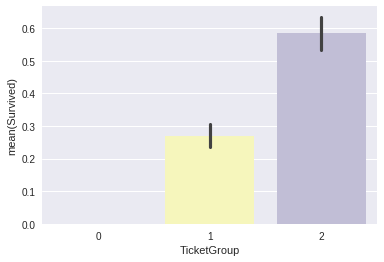

In [14]:
#按生存率把TicketGroup分为三类。
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

In [0]:
#Age Feature：Age缺失量为263，缺失量较大，用Sex, Title, Pclass三个特征构建随机森林模型，填充年龄缺失值。
age_df = all_data[['Age', 'Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[ (all_data.Age.isnull()), 'Age' ] = predictedAges 

In [16]:
#Embarked Feature：Embarked缺失量为2，缺失Embarked信息的乘客的Pclass均为1，且Fare均为80，因为Embarked为C且Pclass为1的乘客的Fare中位数为80，所以缺失值填充为C。
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,B,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,B,2


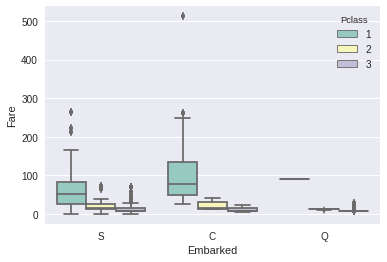

In [17]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass",data=all_data, palette="Set3")

In [0]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [19]:
#Fare Feature：Fare缺失量为1，缺失Fare信息的乘客的Embarked为S，Pclass为3，所以用Embarked为S，Pclass为3的乘客的Fare中位数填充。
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,U,1


In [20]:
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,U,1


In [0]:
fare=all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)

In [0]:
#把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性。
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

In [23]:
#发现绝大部分女性和儿童组的平均存活率都为1或0，即同组的女性和儿童要么全部幸存，要么全部遇难。
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5,0,'AverageSurvived')

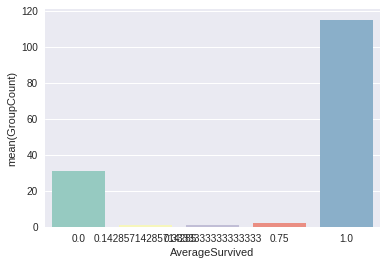

In [25]:
sns.barplot(x=Female_Child.index, y=Female_Child["GroupCount"], palette='Set3').set_xlabel('AverageSurvived')

In [26]:
#绝大部分成年男性组的平均存活率也为1或0。
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


Text(0.5,0,'AverageSurvived')

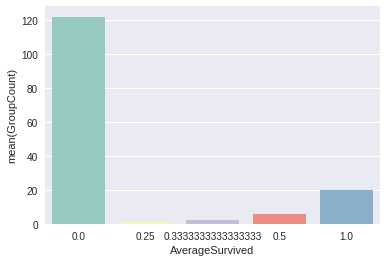

In [27]:
sns.barplot(x=Male_Adult.index, y=Male_Adult['GroupCount'], palette='Set3').set_xlabel('AverageSurvived')

In [28]:
#因为普遍规律是女性和儿童幸存率高，成年男性幸存较低，所以我们把不符合普遍规律的反常组选出来单独处理。
#把女性和儿童组中幸存率为0的组设置为遇难组，把成年男性组中存活率为1的设置为幸存组，推测处于遇难组的女性和儿童幸存的可能性较低，处于幸存组的成年男性幸存的可能性较高。
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)


{'Rosblom', 'Boulos', 'Strom', 'Jussila', 'Van Impe', 'Oreskovic', 'Lahtinen', 'Barbara', 'Danbom', 'Lobb', 'Arnold-Franchi', 'Lefebre', 'Panula', 'Skoog', 'Vander Planke', 'Caram', 'Attalah', 'Palsson', 'Rice', 'Goodwin', 'Robins', 'Canavan', 'Turpin', 'Ford', 'Bourke', 'Olsson', 'Cacic', 'Zabour', 'Sage', 'Johnston', 'Ilmakangas'}
{'Bishop', 'Chambers', 'Frauenthal', 'McCoy', 'Greenfield', 'Bradley', 'Nakid', 'Beane', 'Dick', 'Taylor', 'Kimball', 'Duff Gordon', 'Jonsson', 'Frolicher-Stehli', 'Jussila', 'Cardeza', 'Goldenberg', 'Daly', 'Beckwith', 'Harder'}


In [0]:
#为了使处于这两种反常组中的样本能够被正确分类，对测试集中处于反常组中的样本的Age，Title，Sex进行惩罚修改。
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

In [0]:
#选取特征，转换为数值变量，划分训练集和测试集。
all_data=pd.concat([train, test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]

In [31]:
#用网格搜索自动化选取最优参数。
pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 6, 'classify__n_estimators': 42} 0.8810963508395343


In [45]:
#训练模型
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26, #但是参考另一篇Kernel把参数改为n_estimators = 26，max_depth = 6之后交叉验证分数和kaggle评分都有略微提升。
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x7fc226f658c8>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0....estimators=26, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

In [46]:
#交叉验证
cv_score = cross_validation.cross_val_score(pipeline, X, y, cv= 10)
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))

CV Score : Mean - 0.8451402 | Std - 0.03276752 


In [0]:
#预测
predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("submission.csv", index=False)
files.download('submission.csv')